### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [20]:
# Imports
# pip install imageio matplotlib scikit-learn
# pip install shapely
import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches

In [21]:
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances
from shapely.geometry import Polygon
from shapely.prepared import prep

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images
""

''

In [22]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


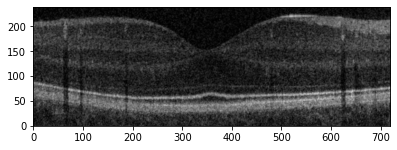

In [83]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [97]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))


    def distance_to(self, other_worm):
        # Calculate the Euclidean distance between the centers of two worms
        distance = np.sqrt((self.x - other_worm.x) ** 2 + (self.y - other_worm.y) ** 2)
        return distance
    
    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = self.intermediate_points()
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[0],point[1]] for point in intermediates]
        return(np.array(colours)/255)
    


In [98]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [99]:
# Example of a random worm. You may do this differently.

    # centre points, angles and colour chosen from uniform distributions
    # lengths chosen from normal distributions with two std parameters passed
    # width chosen from gamma distribution with shape parameter 3 and scale passed

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)


In [100]:
# Initialise a random clew

def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

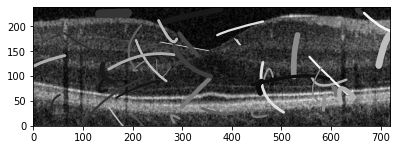

In [101]:
# Initialise clew of 40 and draw

clew = initialise_clew(40, image.shape, (40, 30, 1))
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()

[[200.         180.        ]
 [217.7312124  157.32018935]
 [200.          20.        ]]


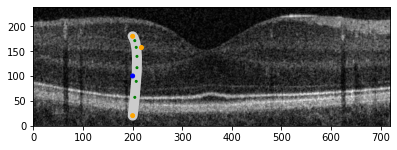

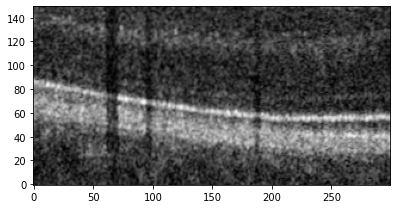

In [102]:
# Draw a single worm along with control points and some sample points

# (x, y, r, theta, deviation_r, deviation_gamma, width, colour)
worm = Camo_Worm(200, 100, 80, np.radians(270), 60, np.pi-0.3, 10, 0.8)
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
drawing.add_dots(worm.control_points(),color='orange')
print(worm.control_points())
drawing.add_dots((200,100), color='blue')
drawing = Drawing(crop(image, [0,150, 0, 300]))

drawing.show(save='bezier.png')

In [110]:
import numpy as np

class CostFunction:
    def __init__(self, image, weights):
        self.image = image
        self.weights = weights

    def internal_cost(self, worm):
        ideal_width = 10
        ideal_length = 500
        total_internal_cost = 0
        if worm.colour < 0.06:
            total_internal_cost += 100
        else :
            total_internal_cost += abs(0.5 - worm.colour) * 10

        # Calculate the worm's features
        worm_width = worm.width
        worm_length = worm.approx_length()

        # Encourage worms with ideal width and length
        total_internal_cost += abs(ideal_width - worm_width) / 2.5
        total_internal_cost += abs(ideal_length - worm_length) / 25

        # print("total_internal_cost", total_internal_cost)
        return total_internal_cost

    def coverage_cost(self, worm, clew):
        coverage_penalty_size = 0
        overlap_penalty = 0
        Avoid_neightbor = False
        Avoid_overlap = True
        # # Calculate intensity change in the region covered by the worm
        # intensity_change = self.calculate_intensity_change(worm)
        # worm_size = self.calculate_worm_size(worm)
        # if (worm.width < 3):
        #     coverage_penalty_size += .2
        # #print("worm size:", worm_size)
        # # Encourage larger worms in areas with little intensity change
        # if (intensity_change >= 3):
        #     if (worm_size <= 240):
        #         coverage_penalty_size += 0.25
        #     else:
        #         # Calculate the size of the worm
        #         coverage_penalty_size += 0.75 + abs((240 - worm_size) / 240)
        # elif (1 <= intensity_change < 3):
        #     if (worm_size <= 500):
        #         coverage_penalty_size += 0.25
        #     else:
        #         # Could be a minor edge, we want the worm to be straighter
        #         coverage_penalty_size += 0.75 + abs((500 - worm_size)/500)
        # else:
        #     if (worm_size >= 900):
        #         Avoid_neightbor = True
        #         Avoid_overlap = False
        #         coverage_penalty_size += 0.25
        #     else:
        #         # Could be a minor edge, we want the worm to be straighter
        #         coverage_penalty_size += 0.75 + abs((900 - worm_size)/900)
        
        #Discourage significant overlapping
        overlap_penalty = self.calculate_overlap_penalty(worm, clew)
        # Total coverage cost
        total_coverage_cost = (coverage_penalty_size + overlap_penalty) #+ overlap_penalty
        #print("total_coverage_cost: size, overlap", total_coverage_cost, coverage_penalty_size, overlap_penalty)
        return total_coverage_cost

    def calculate_intensity_change(self, worm):
        # Get all points along the worm's path        
        path_intensity = []
        num_points = max(int(worm.approx_length() / (worm.width)), 1)
        path = worm.intermediate_points(num_points)
        # Calculate color adaptation cost for each point
        for x, y in path:
            # Ensure coordinates are within the image bounds
            x = max(0, min(int(x), self.image.shape[1] - 1))
            y = max(0, min(int(y), self.image.shape[0] - 1))
            # Sort intensity at each point
            pixel_colour = self.image[y, x].astype(float) / 255
            path_intensity.append(pixel_colour)

        # Calculate the intesity gradients and magnitudes
        gradients = np.zeros(len(path_intensity))
        gradients = abs(np.diff(path_intensity))
        magnitude = sum(gradients)

        return magnitude

    def calculate_worm_size(self, worm):
        total_area = 0
        sampled_points = worm.intermediate_points()
    
        # Calculate the area covered at each sampled point
        for i in range(len(sampled_points) - 1):
            # Calculate the distance between adjacent sampled points
            dx = sampled_points[i + 1][0] - sampled_points[i][0]
            dy = sampled_points[i + 1][1] - sampled_points[i][1]
            segment_length = np.sqrt(dx ** 2 + dy ** 2)
    
            # Use the worm's width at the current point
            width = worm.width  # Assuming constant width for simplicity
    
            # Calculate the area covered by the width at this point
            segment_area = width * segment_length
    
            # Add the segment area to the total area
            total_area += segment_area
    
        return total_area
    def calculate_overlap_penalty(self, worm, worms):
        #close_penalty = 0.0
        overlap_penalty = 0.0
        allowed_overlap = 0.05
        #proximity_threshold = 100
        worm_polygon = Polygon(worm.intermediate_points())
        worm_area = worm_polygon.area
        # worm_prepared = prep(worm_polygon)

        # # Get all points along the worm's path
        # path = worm.intermediate_points(15)
        # width = int(worm.width)

        # for x, y in path:
        #     for clew_worm in worms:
        #         if clew_worm == worm:
        #             continue
        #         neighbour_path = clew_worm.intermediate_points(15)

        #         for nx, ny in neighbour_path:
        #             # Calculate the distance between current point and the worm's closest intermediate point
        #             distance = np.sqrt((x - nx) ** 2 + (y - ny) ** 2)
        #             if distance <= width + clew_worm.width:
        #                 overlap_penalty += 1
        #                 break
        
        for other_worm in worms:
            if other_worm == worm or abs(other_worm.colour - worm.colour) > 0.3:
                continue
            other_worm_polygon = Polygon(other_worm.intermediate_points())
            #distance = worm_polygon.distance(other_worm_polygon)
            #print(distance)
            #close_penalty += max(0.0, proximity_threshold - distance)
            # other_worm_prepared = prep(other_worm_polygon)
            if worm_polygon.intersects(other_worm_polygon):
                # Calculate the overlapping area as a percentage of the worm's area
                intersection_area = worm_polygon.intersection(other_worm_polygon).area
                overlapping_percent = intersection_area / worm_area
                #print(overlapping_percent)
                overlap_penalty += max(0.0, overlapping_percent - allowed_overlap) / (1 - allowed_overlap)
        
        overall_penalty = 10 * overlap_penalty #+.4 * close_penalty  
        # print("overlap_penalty", overlap_penalty)
        return overall_penalty

    def smoothness_cost(self, worm):
        '''
        Considering the worm's curvature and length with respect to 
        the layer changes (i.e., intensity changes).
        '''
        total_smoothness_cost = 0
        detail = 100
        ideal_length = 200
        # ideal_curves = {"no-edge": 200, "slight-edge": 100, "edge": 10}
        path_intensity = [[],[]]

        # Get 100 points along the worm's path
        path = np.array(worm.intermediate_points(detail))
        p0 ,p1 = worm.control_points()[0], worm.control_points()[2]

        # Calculate color adaptation cost for each point
        for x, y in path:
            # Ensure coordinates are within the image bounds
            x = max(0, min(int(x), self.image.shape[1] - 1))
            y = max(0, min(int(y), self.image.shape[0] - 1))
            # Sort intensity at each point
            pixel_colour = self.image[y, x].astype(float) / 255
            path_intensity[1].append([x,y])
            path_intensity[0].append(pixel_colour)

        # Calculate the intesity gradients and magnitudes
        gradients = abs(np.diff(path_intensity[0]))
        edge_point = path_intensity[1][np.argmax(gradients)]
        magnitude = sum(gradients)
        # print("################# NEW WORM #################")
        # print(f"path_intensity:{path_intensity}")
        # print(f"edge_point_index: {edge_point_index}, (x,y) = {path_intensity[1][edge_point_index]}")
        # print(f"gradient:{gradients}")
        # print(f"magnitude:{magnitude}")
        # drawing = Drawing(self.image)
        # drawing.add_worms(worm)
        # drawing.add_dots(worm.control_points(),color='orange')
        # drawing.add_dots(path_intensity[1][edge_point_index],color='blue')
        # drawing.show()

        # Get the worm's features
        worm_curvature = worm.dr
        worm_curve_direct = worm.dgamma
        worm_orientation = worm.theta
        worm_length = worm.approx_length()

        worm_curvature_point = worm.control_points()[1]
        if magnitude >= 2:
            # Large change of intensity, worm is on top of an edge
            total_smoothness_cost += abs(worm_curvature)/magnitude
            total_smoothness_cost += abs(worm_orientation*magnitude) % (2*np.pi)
            total_smoothness_cost += abs(worm_curve_direct*magnitude) % (2*np.pi)
        elif 1 <= magnitude < 2:
            # Slight change in intensity, worm is still on top of an edge
            total_smoothness_cost += abs(worm_curvature_point[0]-edge_point[0])/10
            total_smoothness_cost += abs(worm_curvature_point[1]-edge_point[1])/10
            total_smoothness_cost += abs(worm_orientation/magnitude) % (2*np.pi)
            # total_smoothness_cost += abs(worm_curve_direct/magnitude)
        else:
            # Small or no change in intensity in the worm
            total_smoothness_cost += abs(ideal_length-worm_length)/ideal_length
            total_smoothness_cost += abs(100/worm_curvature)
        # print(f"SMOOTHNESS COST: {total_smoothness_cost}\n")
        return 10 * total_smoothness_cost


    def detail_preservation_cost(self, worm): 
        
        total_detail_cost = 0

        # Define parameters for detail preservation evaluation
        preferred_distance = 50  # Adjust as needed for the distance from other worms
        overlap_penalty = 0

        # Calculate the effect of neighboring worms on the original worm
        for other_worm in clew:
            if other_worm == worm:
                continue

            # Calculate the distance between the original worm and the neighboring worm
            distance = worm.distance_to(other_worm)

            # If the distance is less than the preferred distance, penalize detail preservation
            if distance < preferred_distance:
                overlap_penalty += 1

        # Accumulate the overlap penalty as the detail preservation cost
        total_detail_cost += overlap_penalty

        return total_detail_cost

    def colour_adaptation_cost(self, worm):
        # Initialize total colour cost
        total_colour_cost = 0

        # Get all points along the worm's path
        num_points = max(int(worm.approx_length() / (worm.width)), 1)
        path = worm.intermediate_points(num_points)

        # Get worm's colour and width
        colour = worm.colour
        width = int(worm.width)
        checked_points = []
        total_colour_cost_added = 0

        # Calculate colour adaptation cost for each point
        for x, y in path:
            # Ensure coordinates are within the image bounds
            x = max(0, min(int(x), self.image.shape[1] - 1))
            y = max(0, min(int(y), self.image.shape[0] - 1))

            for dx in range(-width, width + 1):
                for dy in range(-width, width + 1):
                    if (dx, dy) not in checked_points:
                        checked_points.append((dx, dy))
                        # Check coordinates are within the image bounds
                        nx = max(0, min(int(x + dx), self.image.shape[1] - 1))
                        ny = max(0, min(int(y + dy), self.image.shape[0] - 1))

                        # Calculate the distance between current point and the worm's closest intermediate point
                        distance = np.sqrt((x - nx) ** 2 + (y - ny) ** 2)

                        # If the distance is less than the worm's width, calculate the color difference
                        if distance <= width:
                            # Calculate colour difference between worm and image at each point
                            image_colour = self.image[ny, nx].astype(float) / 255
                            colour_difference = np.linalg.norm(colour - image_colour)
                            
                            # Accumulate colour adaptation cost
                            total_colour_cost += colour_difference
                            total_colour_cost_added += 1

        # print(f"COLOUR ADAPTATION COST: {50 * total_colour_cost / total_colour_cost_added}\n")
        return 50 * total_colour_cost / total_colour_cost_added

    def efficiency_cost(self, worm):
        pass

    def evaluate(self, worm, clew):
        # Evaluate the total cost
        internal_cost = self.internal_cost(worm)
        coverage_cost = self.coverage_cost(worm, clew)
        smoothness_cost = self.smoothness_cost(worm)
        detail_cost = self.detail_preservation_cost(worm)
        colour_cost = self.colour_adaptation_cost(worm)
        efficiency_cost = 0 #self.efficiency_cost(worm)

        total_cost = (self.weights['internal'] * internal_cost +
                      self.weights['coverage'] * coverage_cost +
                      self.weights['smoothness'] * smoothness_cost +
                      self.weights['detail'] * detail_cost +
                      self.weights['colour'] * colour_cost +
                      self.weights['efficiency'] * efficiency_cost)

        return total_cost

In [111]:
import random

class GeneticAlgorithm:
    def __init__(self, image, population_size, crossover_rate, mutation_rate, weights):
        self.image = image
        self.population_size = population_size 
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.weights = weights

    def initialise_population(self, image_shape, init_params):
        population = [random_worm(image_shape, init_params) for _ in range(self.population_size)]
        return population

    def select_parents(self, population):
        # Select parents based on fitness
        tournament_size = 5
        parents = []
        for _ in range(self.population_size):
            # ------------ Replace with Different Function------------
            tournament_indices = np.random.choice(range(len(population)), tournament_size, replace=False)
            tournament = [population[i] for i in tournament_indices]
            winner = random.choice(tournament)
            parents.append(winner)
        return parents

    def crossover(self, parent1, parent2):
        # Crossover parents to create offspring
        params = ['x', 'y', 'r', 'theta', 'dr', 'dgamma', 'width', 'colour']

        # Get other parameters from parents
        p1 = np.zeros(len(params))
        p2 = np.zeros(len(params))
        for i, param in enumerate(params):
            if random.random() < self.crossover_rate:
                p1[i] = getattr(parent2, param)
                p2[i] = getattr(parent1, param)
            else:
                p1[i] = getattr(parent1, param)
                p2[i] = getattr(parent2, param)
        
        return p1, p2

    def mutate(self, worm_params, init_params):
        # Mutate offspring
        # Randomly select any parameters of the worm and mutate it
        params = ['x', 'y', 'r', 'theta', 'dr', 'dgamma', 'width', 'colour']
        (radius_std, deviation_std, width_theta) = init_params
        for i, param in enumerate(params):
            if random.random() < self.mutation_rate:
                if param == 'x':
                    worm_params[i] = self.image.shape[1] * rng.random()
                elif param == 'y':
                    worm_params[i] = self.image.shape[0] * rng.random()
                elif param == 'r':
                    worm_params[i] = radius_std * np.abs(rng.standard_normal())
                elif param == 'theta':
                    worm_params[i] = rng.random() * np.pi
                elif param == 'dr':
                    worm_params[i] = deviation_std * np.abs(rng.standard_normal())
                elif param == 'dgamma':
                    worm_params[i] = rng.random() * np.pi
                elif param == 'width':
                    worm_params[i] = width_theta * rng.standard_gamma(3)
                elif param == 'colour':
                    worm_params[i] = rng.random()
        return worm_params
    
    def run(self, max_generations, init_params):
        # Initialize population
        population = self.initialise_population(self.image.shape, init_params)
        cost = CostFunction(image, self.weights)

         # ------------ Add Cost_function to offspring------------
        for generation in range(max_generations):
            # Select parents
            parents = self.select_parents(population)

            # Create offspring through crossover
            offspring = []
            for i in range(0, self.population_size, 2):
                child_param1, child_param2 = self.crossover(parents[i], parents[i+1])
                child_param1= self.mutate(child_param1, init_params)
                child_param2= self.mutate(child_param2, init_params)
                child1 = Camo_Worm(*child_param1)
                child2 = Camo_Worm(*child_param2)
                offspring.extend([child1, child2])
            
            # add parents and offspring together
            new_population = population + offspring

            # Evaluate the cost of each worm in the new population
            pop_cost = [cost.evaluate(worm, new_population) for worm in new_population]
            # Get the indices of worms sorted by their costs in ascending order
            sorted_indices = sorted(range(len(pop_cost)), key=lambda k: pop_cost[k])
            sorted_population = [new_population[i] for i in sorted_indices]

            # Replace old population with new population
            population = sorted_population[:self.population_size]
            total_cost = sum([pop_cost[i] for i in sorted_indices[:self.population_size]])
            if generation % 10 == 0:
                print("total cost of generation", generation, ":", total_cost)
 
        return population

total cost of generation 0 : 9681.906864409952


C:\Users\Sk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shapely\predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
C:\Users\Sk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shapely\set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
C:\Users\Sk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shapely\predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
C:\Users\Sk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shapely\set_operations.py:131: RuntimeWarning: invalid value encountered in int

total cost of generation 10 : 4811.848296196701
total cost of generation 20 : 4094.4919742051757


C:\Users\Sk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shapely\predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
C:\Users\Sk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shapely\set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
C:\Users\Sk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shapely\predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
C:\Users\Sk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shapely\set_operations.py:131: RuntimeWarning: invalid value encountered in int

total cost of generation 30 : 3887.9650186030453


C:\Users\Sk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shapely\predicates.py:778: RuntimeWarning: divide by zero encountered in intersects
  return lib.intersects(a, b, **kwargs)
C:\Users\Sk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shapely\set_operations.py:131: RuntimeWarning: divide by zero encountered in intersection
  return lib.intersection(a, b, **kwargs)
C:\Users\Sk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shapely\predicates.py:778: RuntimeWarning: divide by zero encountered in intersects
  return lib.intersects(a, b, **kwargs)
C:\Users\Sk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shapely\set_operations.py:131: RuntimeWarning: divide by zero encountered in

total cost of generation 40 : 3767.069729282321


C:\Users\Sk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shapely\predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
C:\Users\Sk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shapely\set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
C:\Users\Sk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shapely\predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
C:\Users\Sk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shapely\set_operations.py:131: RuntimeWarning: invalid value encountered in int

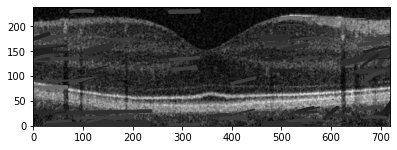

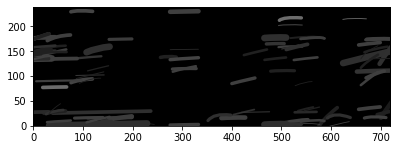

In [112]:
# Define parameters for the Genetic Algorithm
population_size = 100 # Number of worms in the population ---- to be adjusted
crossover_rate = 0.5 # Probability of crossover
mutation_rate = 0.1 # Probability of mutation`

# Define weights --- to be adjusted/required?
weights = {'internal': 1, 'coverage': 1, 'smoothness': 1, 'detail': 1, 'colour': 1, 'efficiency': 1}

# Create an instance of the GeneticAlgorithm class
genetic_algorithm = GeneticAlgorithm(image, population_size, crossover_rate, mutation_rate, weights)

# Define initial parameters for the worms
init_params = (40, 30, 1)  # Example parameters, adjust as needed

# Define the maximum number of generations
max_generations = 50
clew = genetic_algorithm.run(max_generations, init_params)

# Display the optimized population of worms
drawing = Drawing(image)
for worm in clew:
    drawing.add_worms(worm)


# # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# # Testing cost function for a single worm
# worm_test = Camo_Worm(100, 180, 50, np.pi/6, 70, np.pi/4, 10, 0.6)
# worm_test2 = Camo_Worm(300, 160, 50, np.pi/6, 70, np.pi/4, 8, 0.6)
# test = ['x', 'y', 'r', 'theta', 'dr', 'dgamma', 'width', 'colour']
# print(worm_test)
# cost = CostFunction(image, weights)
# c_c = cost.evaluate(worm_test, [worm_test, worm_test2])
# print(c_c)
# drawing.add_worms(worm_test)
# drawing.add_worms(worm_test2)
drawing.show()

# blank drawing
blank_drawing = Drawing(np.full((240, 720), 0, dtype=np.uint8))
for worm in clew:
    blank_drawing.add_worms(worm)
blank_drawing.show()


In [ ]:
for print_worm in clew:
    cost = CostFunction(image, weights)
    c_c = cost.evaluate(print_worm, clew)
    print(c_c)

26.91040426907057
27.416650522719852
27.51982047164745
27.780476786089995
28.232006158596743
28.475133244047445
28.876265817163002
29.14685929799798
28.58425090537482
29.22930898494456
29.24901402850358
29.301739644084677
29.440109911003933
29.54180215349883
29.738332084995676
29.880586322618704
30.116985921501357
30.200662208440296
30.54579020139391
30.56811391382406
30.586841360385264
30.61755800481175
30.948013002427164
31.09679144352966
31.115235669109296
30.099076491987933
31.2305203455661
31.373662113669983
31.39773293116458
31.507350212865312
31.509054816969815
31.760346257111586
30.870908662850773
31.830631611261595
31.996101190947492
32.07733588773345
32.16516618723349
32.179903542827056
31.922527062795577
32.34503590981699
32.576099372099485
32.57756798775854
32.58627897148074
32.64355231451495
32.964922277054676
33.000447240444906
33.18812055495545
33.18825555253141
33.21773373377686
33.26131877775667
33.34816355389387
33.38967436352111
33.524971569895406
33.6331354176622
33

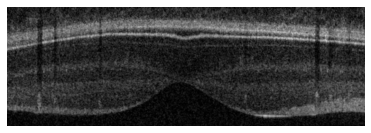

In [ ]:
def display_grayscale_image(color, size=(240, 720)):
    """Display a grayscale image of specified color and size."""
    blank_image = np.full((240, 720), 255, dtype=np.uint8)
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')  # Turn off axis
    plt.show()

# Example: Display a white image (255 intensity)
display_grayscale_image(255)  # All white image

&copy; Cara MacNish, UWA, 2024